In [552]:
import pandas as pd
import numpy as np
# from dotenv import load_dotenv
from pandas.tseries.offsets import DateOffset
import os
import requests
import datetime
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.requests import CryptoLatestQuoteRequest
from alpaca.data.requests import CryptoTradesRequest
from alpaca.data.timeframe import TimeFrame
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt

%matplotlib inline

## Data Retreival/Formatting

In [553]:
# alpaca_api_key = os.getenv("ALPACA_API_KEY")
# alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [554]:
# type(alpaca_api_key)

In [555]:
crypto_client = CryptoHistoricalDataClient()

In [556]:
request_params = CryptoBarsRequest(
    symbol_or_symbols=["ETH/USD"],
    timeframe=TimeFrame.Hour, start='2021-09-30 00:00:00'
)

eth_bars = crypto_client.get_crypto_bars(request_params)

eth_df = eth_bars.df

eth_df

open    high     low   close    volume  \
symbol  timestamp                                                             
ETH/USD 2021-09-30 00:00:00+00:00  2849.8  2934.8  2838.3  2934.2   706.304   
        2021-09-30 01:00:00+00:00  2935.8  2985.4  2918.2  2961.0   760.251   
        2021-09-30 02:00:00+00:00  2965.4  2994.4  2961.1  2990.6  3886.627   
        2021-09-30 03:00:00+00:00  2992.0  3035.8  2970.0  3029.0  5551.980   
        2021-09-30 04:00:00+00:00  3030.3  3049.2  3014.0  3017.1   401.627   
...                                   ...     ...     ...     ...       ...   
        2022-10-01 13:00:00+00:00  1322.4  1329.8  1321.2  1325.7  1099.010   
        2022-10-01 14:00:00+00:00  1325.8  1326.8  1322.1  1322.8   986.555   
        2022-10-01 15:00:00+00:00  1322.7  1325.2  1320.7  1322.2   686.300   
        2022-10-01 16:00:00+00:00  1322.6  1323.9  1306.4  1310.9  4058.109   
        2022-10-01 17:00:00+00:00  1310.9  1311.7  1309.0  1309.4    16.539   

                                   trade_count         vwap  
symbol  timestamp                                            
ETH/USD 2021-09-30 00:00:00+00:00        393.0  2887.453790  
        2021-09-30 01:00:00+00:00        352.0  2957.585712  
        2021-09-30 02:00:00+00:00        573.0  2975.692584  
        2021-09-30 03:00:00+00:00        669.0  2991.111283  
        2021-09-30 04:00:00+00:00        115.0  3030.674760  
...                                        ...          ...  
        2022-10-01 13:00:00+00:00       1019.0  1324.245673  
        2022-10-01 14:00:00+00:00        793.0  1324.474357  
        2022-10-01 15:00:00+00:00        817.0  1322.259673  
        2022-10-01 16:00:00+00:00       1934.0  1313.036423  
        2022-10-01 17:00:00+00:00         51.0  1310.362616  

[8784 rows x 7 columns]

In [557]:
eth_df.dtypes

open           float64
high           float64
low            float64
close          float64
volume         float64
trade_count    float64
vwap           float64
dtype: object

In [558]:
eth_df = eth_df.reset_index()
eth_df = eth_df.set_index('timestamp')
eth_df = eth_df.drop(columns=['symbol'])

eth_df

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2021-09-30 00:00:00+00:00,2849.8,2934.8,2838.3,2934.2,706.304,393.0,2887.453790
2021-09-30 01:00:00+00:00,2935.8,2985.4,2918.2,2961.0,760.251,352.0,2957.585712
2021-09-30 02:00:00+00:00,2965.4,2994.4,2961.1,2990.6,3886.627,573.0,2975.692584
2021-09-30 03:00:00+00:00,2992.0,3035.8,2970.0,3029.0,5551.980,669.0,2991.111283
2021-09-30 04:00:00+00:00,3030.3,3049.2,3014.0,3017.1,401.627,115.0,3030.674760
...,...,...,...,...,...,...,...
2022-10-01 13:00:00+00:00,1322.4,1329.8,1321.2,1325.7,1099.010,1019.0,1324.245673
2022-10-01 14:00:00+00:00,1325.8,1326.8,1322.1,1322.8,986.555,793.0,1324.474357
2022-10-01 15:00:00+00:00,1322.7,1325.2,1320.7,1322.2,686.300,817.0,1322.259673


In [559]:
# Use the pct_change function to generate  returns from close prices
eth_df["Actual Returns"] = eth_df["close"].pct_change()

# Drop na
eth_df=eth_df.dropna()

In [560]:
# Initialize the new Signal column
eth_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
eth_df.loc[(eth_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
eth_df.loc[(eth_df['Actual Returns'] < 0), 'Signal'] = -1

eth_df

C:\Users\gtkhh\AppData\Local\Temp\ipykernel_18584\576034806.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth_df['Signal'] = 0.0


,open,high,low,close,volume,trade_count,vwap,Actual Returns,Signal
timestamp,,,,,,,,,
2021-09-30 01:00:00+00:00,2935.8,2985.4,2918.2,2961.0,760.251,352.0,2957.585712,0.009134,1.0
2021-09-30 02:00:00+00:00,2965.4,2994.4,2961.1,2990.6,3886.627,573.0,2975.692584,0.009997,1.0
2021-09-30 03:00:00+00:00,2992.0,3035.8,2970.0,3029.0,5551.980,669.0,2991.111283,0.012840,1.0
2021-09-30 04:00:00+00:00,3030.3,3049.2,3014.0,3017.1,401.627,115.0,3030.674760,-0.003929,-1.0
2021-09-30 05:00:00+00:00,3023.0,3041.3,3019.5,3029.7,141.883,108.0,3025.002656,0.004176,1.0
...,...,...,...,...,...,...,...,...,...
2022-10-01 13:00:00+00:00,1322.4,1329.8,1321.2,1325.7,1099.010,1019.0,1324.245673,0.002495,1.0
2022-10-01 14:00:00+00:00,1325.8,1326.8,1322.1,1322.8,986.555,793.0,1324.474357,-0.002188,-1.0
2022-10-01 15:00:00+00:00,1322.7,1325.2,1320.7,1322.2,686.300,817.0,1322.259673,-0.000454,-1.0


In [561]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = eth_df[['open', 'high','low','close','volume', 'trade_count']].shift().dropna()

# Review the DataFrame
X.head()

,open,high,low,close,volume,trade_count
timestamp,,,,,,
2021-09-30 02:00:00+00:00,2935.8,2985.4,2918.2,2961.0,760.251,352.0
2021-09-30 03:00:00+00:00,2965.4,2994.4,2961.1,2990.6,3886.627,573.0
2021-09-30 04:00:00+00:00,2992.0,3035.8,2970.0,3029.0,5551.980,669.0
2021-09-30 05:00:00+00:00,3030.3,3049.2,3014.0,3017.1,401.627,115.0
2021-09-30 06:00:00+00:00,3023.0,3041.3,3019.5,3029.7,141.883,108.0


In [562]:
# Create the target set selecting the Signal column and assiging it to y
y = eth_df['Signal']

# Review the value counts
y

timestamp
2021-09-30 01:00:00+00:00    1.0
2021-09-30 02:00:00+00:00    1.0
2021-09-30 03:00:00+00:00    1.0
2021-09-30 04:00:00+00:00   -1.0
2021-09-30 05:00:00+00:00    1.0
                            ... 
2022-10-01 13:00:00+00:00    1.0
2022-10-01 14:00:00+00:00   -1.0
2022-10-01 15:00:00+00:00   -1.0
2022-10-01 16:00:00+00:00   -1.0
2022-10-01 17:00:00+00:00   -1.0
Name: Signal, Length: 8783, dtype: float64

In [563]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2021-09-30 02:00:00+00:00


In [564]:
# Select the ending period for the training data with an offset of 12 months
training_end = X.index.min() + DateOffset(months=6)

# Display the training end date
print(training_end)

2022-03-30 02:00:00+00:00


In [565]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
display(X_train)
display(y_train)

,open,high,low,close,volume,trade_count
timestamp,,,,,,
2021-09-30 02:00:00+00:00,2935.8,2985.4,2918.2,2961.0,760.251,352.0
2021-09-30 03:00:00+00:00,2965.4,2994.4,2961.1,2990.6,3886.627,573.0
2021-09-30 04:00:00+00:00,2992.0,3035.8,2970.0,3029.0,5551.980,669.0
2021-09-30 05:00:00+00:00,3030.3,3049.2,3014.0,3017.1,401.627,115.0
2021-09-30 06:00:00+00:00,3023.0,3041.3,3019.5,3029.7,141.883,108.0
...,...,...,...,...,...,...
2022-03-29 22:00:00+00:00,3397.0,3403.0,3362.4,3377.1,8587.049,4588.0
2022-03-29 23:00:00+00:00,3376.1,3391.4,3345.1,3386.3,561.135,728.0
2022-03-30 00:00:00+00:00,3385.7,3406.2,3378.5,3402.6,118.148,252.0


timestamp
2021-09-30 02:00:00+00:00    1.0
2021-09-30 03:00:00+00:00    1.0
2021-09-30 04:00:00+00:00   -1.0
2021-09-30 05:00:00+00:00    1.0
2021-09-30 06:00:00+00:00   -1.0
                            ... 
2022-03-29 22:00:00+00:00    1.0
2022-03-29 23:00:00+00:00    1.0
2022-03-30 00:00:00+00:00   -1.0
2022-03-30 01:00:00+00:00   -1.0
2022-03-30 02:00:00+00:00    1.0
Name: Signal, Length: 4345, dtype: float64

In [566]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_test


,open,high,low,close,volume,trade_count
timestamp,,,,,,
2022-03-30 03:00:00+00:00,3345.6,3380.0,3343.6,3372.8,815.337,597.0
2022-03-30 04:00:00+00:00,3372.0,3389.6,3372.0,3385.2,88.532,198.0
2022-03-30 05:00:00+00:00,3385.3,3392.7,3364.0,3372.0,322.144,259.0
2022-03-30 06:00:00+00:00,3371.9,3409.1,3370.4,3405.9,415.743,366.0
2022-03-30 07:00:00+00:00,3405.1,3417.9,3392.2,3405.9,248.753,315.0
...,...,...,...,...,...,...
2022-10-01 13:00:00+00:00,1325.3,1326.1,1319.7,1322.4,609.502,889.0
2022-10-01 14:00:00+00:00,1322.4,1329.8,1321.2,1325.7,1099.010,1019.0
2022-10-01 15:00:00+00:00,1325.8,1326.8,1322.1,1322.8,986.555,793.0


In [567]:
# Scale the features DataFrames

# Create a StandardScaler instance

scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

X_train_scaled.shape

(4345, 6)

## Model Creation

In [568]:
# Define the the number of inputs (features) to the model
number_input_features = len(X.columns)

# Review the number of features
number_input_features


6

In [569]:
# Define the number of neurons in the output layer
number_output_neurons = 1

In [570]:
# Define the number of hidden nodes for the second hidden layer
hidden_nodes_layer2 = (hidden_nodes_layer1 + 1) //2

# Review the number hidden nodes in the second layer
hidden_nodes_layer2


32

In [571]:
# Create the Sequential model instance
nn = Sequential()

# Define the number of neurons in the output layer
number_output_neurons = 1

# Define the number of hidden nodes for the first hidden layer
# hidden_nodes_layer1 = (number_input_features + 1) // 2
hidden_nodes_layer1 = 64

# Review the number hidden nodes in the first layer
display(hidden_nodes_layer1)

# Define the number of hidden nodes for the second hidden layer
# hidden_nodes_layer2 = (hidden_nodes_layer1 + 1) //2
hidden_nodes_layer2 = 64

# Review the number hidden nodes in the second layer
display(hidden_nodes_layer2)

64

64

In [572]:
# Create the Sequential model instance
nn = Sequential()

In [573]:
# Add the first hidden layer
nn.add(LSTM(64, input_shape=(None,6)))

In [574]:
# Add the second hidden layer
# nn.add(LSTM(units=hidden_nodes_layer2))


In [575]:
# Add the output layer to the model specifying the number of output neurons and activation function
nn.add(Dense(units=1,  activation='sigmoid'))


In [576]:
# Display the Sequential model summary
nn.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_45 (LSTM)              (None, 64)                18176     
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                                                                 
Total params: 18,241
Trainable params: 18,241
Non-trainable params: 0
_________________________________________________________________


In [577]:
# Compile the Sequential model
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

In [578]:
# Fit the model using 50 epochs and the training data
model_01 = nn.fit(X_train_scaled, y_train, epochs=20)

Epoch 1/20


ValueError: in user code:

    File "c:\Users\gtkhh\anaconda3\envs\dev\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\gtkhh\anaconda3\envs\dev\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\gtkhh\anaconda3\envs\dev\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\gtkhh\anaconda3\envs\dev\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\gtkhh\anaconda3\envs\dev\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\gtkhh\anaconda3\envs\dev\lib\site-packages\keras\engine\input_spec.py", line 232, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential_38" "                 f"(type Sequential).
    
    Input 0 of layer "lstm_45" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 6)
    
    Call arguments received by layer "sequential_38" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(None, 6), dtype=float32)
      • training=True
      • mask=None


In [ ]:
# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
model_loss, model_accuracy = nn.evaluate(X_test, y_test)

# Display the model loss and accuracy results
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

139/139 [==============================] - 1s 4ms/step - loss: -0.4945 - accuracy: 0.0000e+00
Loss: -0.4944511950016022, Accuracy: 0.0


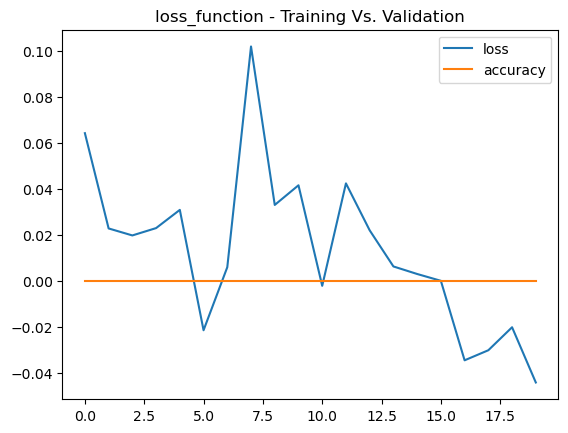

In [ ]:
# Train vs test for loss
plt.plot(model_01.history["loss"])
plt.plot(model_01.history["accuracy"])
plt.title("loss_function - Training Vs. Validation")
plt.legend(["loss", "accuracy"])
plt.show()